In [1]:
%matplotlib inline
from scipy.io import loadmat,savemat
from scipy.linalg import *
from numpy import *
from os import listdir
import pickle,operator
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

In [3]:
titaniumDat = loadmat('alphatitaniumsmall.mat')
volumefraction = constraint = titaniumDat['volumefraction'][0]

### <font color="red">Objective: Maximize the stiffness coefficient C11</font>

### <font color="orange"> Design Constraint: C12 stiffness coefficient should be greater than 75 GPa.</font>


### <font color="green">max C11</font>
subject to :
###  C12>75 GPa and C12< 78 GPa



In [4]:
C11_limit = (75,78)
alpha_limit = {'C11':(161,165), 'C12':C11_limit}

### <font color="teal">Optimum polycrystal solution C11 =  167.8562  GPa</font>
#### with 
##### <font color="blue">C12 = 75.2360 GPa</font>

In [5]:
def FiveSig(x):
    return float("{0:.5f}".format(x))

In [6]:
def Plot(x,y,labelX="",labelY="",title=""):
    plt.plot(x,y)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)

In [7]:
def loadData(name,path):
    '''
    This loads a pickle file and returns the content which is a DICTIONARY object in our case.
    '''
    if ".pkl" in name:
            name = name.split(".pkl")[0]
    if "/" in name:
            name = name.split("/",1)[1]

    with open(path+"/"+name + '.pkl', 'rb') as f:
          return pickle.load(f)

def saveData(obj, name,path):
    '''
    This saves a object into a pickle file. In our case, it is generally a DICTIONARY object.
    '''

    with open(path+"/"+name + '.pkl', 'wb') as f:
            pickle.dump(obj, f)#, pickle.HIGHEST_PROTOCOL)
            
def loadNumpy(name,path='numpyData'):
    fullPath = path+'/'+name+'.npy'
    return load(fullPath)
    

def saveNumpy(obj, name, path='numpyData'):
    fullPath = path+'/'+name
    save(fullPath, obj)
    print name,'saved successfully in',path

In [8]:
def getC12(odf):

    C = stiffness.dot(odf).reshape(6,6);  # averaged stiffness matrix
    C12 = C[0][1]
    return C12

In [9]:
def getSum(odf):
    Sum = 0
    for i in range(50):
        Sum += volumefraction[i]*odf[i]
    return Sum

def checkSum(odf):
    Sum = FiveSig(getSum(odf))
    if Sum !=1.0:
        return False
    else:
        return True

In [10]:
def posOdf(odf):
    return nonzero(odf)[0].tolist()

### <font color="purple">Sorting the solutions for finding near-optimal solutions</font>


In [12]:
data = []

Filename = []
for File in listdir('C11UpperData'):

    Filename += [File]
    data += [loadmat('C11UpperData/'+File)]



In [13]:
len(data[0]['Data'][0])

391

In [19]:
opts = []
odfs = []
constraints = []
# sortedOpts = []
# sortedConstraints = []

maxOdf = [[0]*50]*len(data)#, maxOdf]#, maxOdf]#, maxOdf]
maxOpt = [0]*len(data)#4
maxConstraint = [0]*len(data)

count = 0
total = 0

for i in range(len(data)):
    for odf in data[i]['Data']:
        
        odf = odf.tolist()
        opts += [odf[50]]
        constraints += [odf[51]]
        
        odfs += [odf[:50]]
        
        total += 1
        
        if checkSum(odf[:50]):
            count += 1

        if odf[50]>maxOpt[i]:
            maxOpt[i] = odf[50]
            maxConstraint[i] = odf[51]
            maxOdf[i] = odf[:50]

In [20]:
combined = zip(constraints,opts,odfs)
combined.sort(key=lambda x:map(int, str(float(x[1])).split(".")), reverse=True)
constraints[:],opts[:],odfs[:] = zip(*combined)

In [23]:
saveNumpy(constraints,'sortedConstraints_C11')
saveNumpy(odfs,'sortedOdfs_C11')
saveNumpy(opts,'sortedOpts_C11')

sortedConstraints_C11 saved successfully in numpyData
sortedOdfs_C11 saved successfully in numpyData
sortedOpts_C11 saved successfully in numpyData


### <font color = "orange"> Solutions close to LP solution </font>

In [40]:
LP = 167.8562
limit1 = 0.99 *LP
limit2 = 0.995 *LP
limit3 = 0.999 * LP
limit4 = 0.9999 * LP
limit1,limit2,limit3,limit4

(166.177638, 167.016919, 167.6883438, 167.83941438)

In [41]:
count1,count2,count3,count4 = 0,0,0,0
flag,i = True,-1
flag1,flag2 = -1,-1
while flag:
    i+=1
    if opts[i]>limit1:
        count1 += 1
        if opts[i]>limit2:
            count2 += 1
            if opts[i]>limit3:
                count3 += 1
                if opts[i]>limit4:
                    count4 += 1
    else:
        flag = False

print count1, count2, count3,count4

3544 237 30 3


### <font color="teal"> Other Odf combinations </font>

In [46]:
otherSols = []
for i in range(50):
    pos_odf = posOdf(odfs[i])
    if  pos_odf != [0, 29]:
        print i,pos_odf

8 [0, 20, 29]
20 [0, 9, 29, 37]
35 [0, 27, 29]
36 [0, 7, 29]
37 [0, 11, 26, 29]
40 [0, 29, 32]
44 [0, 10, 24, 29]
46 [0, 29, 47]


### <font color="green"> Random Forest Regression to find the top features for determining value </font> 

In [48]:
edgeOdfs = odfs[:5000]+odfs[-5000:]
edgeLabels = opts[:5000]+opts[-5000:]

edgeOdfs,edgeLabels = shuffle(edgeOdfs,edgeLabels)

In [50]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(edgeOdfs, edgeLabels)
features = clf.feature_importances_
indices = argsort(features)[::-1]
values = sorted(features, reverse=True)
for i in range(4):
    print indices[i], ':',values[i]

4 : 0.517520455566
3 : 0.480709514167
29 : 0.00171514648206
11 : 5.48837848748e-05


### <font color="magenta"> Plots </font>

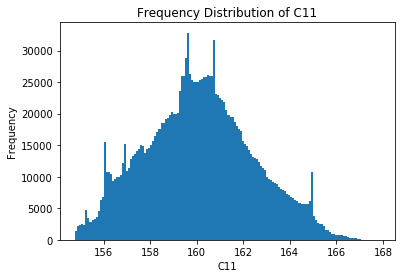

In [24]:
plt.hist(opts,bins=150)
plt.title("Frequency Distribution of C11")
plt.xlabel("C11")
plt.ylabel("Frequency")
plt.show()

In [15]:
for i in range(len(data)):
    print i,Filename[i],maxOpt[i],maxConstraint[i]

0 C11_first4Generator_100000.mat 166.93191721 75.1231506878
1 C11_first5Generator_1000000.mat 166.584798468 75.0268834006
2 C11_first6Generator_20000.mat 166.089132765 75.2459881999
3 C11_first7Generator_40000.mat 165.503543442 75.084243082
4 C11_SmallPartition12_100000.mat 165.371825616 75.0221308183
5 C11_SmallPartition15_100000.mat 164.507248324 75.2602581336
6 C11_SmallPartition2_150000.mat 167.828929238 75.015094798
7 C11_SmallPartition2_300000.mat 167.779424738 75.0425390511
8 C11_SmallPartition2_5000000.mat 167.854859813 75.0007194329
9 C11_SmallPartition3_300000.mat 167.503662405 75.0975896265
10 C11_SmallPartition3_5000000.mat 167.806524039 75.0138587938
11 C11_SmallPartition4_300000.mat 167.171631144 75.1946370314
12 C11_SmallPartition4_5000000.mat 167.737438313 75.0135342635
13 C11_SmallPartition5_100000.mat 167.288739258 75.1066871266
14 C11_SmallPartition5_300000.mat 166.982447955 75.044842377
15 C11_SmallPartition6_100000.mat 166.620159578 75.0781259976
16 C11_SmallPartit

In [26]:
indices = list(range(50))

In [27]:
List = []
for i in range(50):
    List += [0]
    
for odf in odfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        List[elem] += 1

average = []
for i in indices:
    average += [float(List[i])/float(len(odfs))]

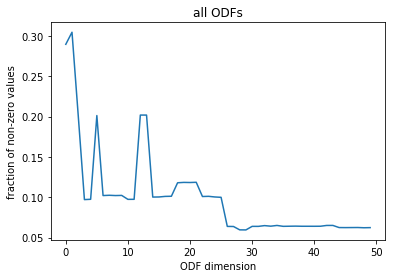

In [28]:
Plot(indices, average,"ODF dimension","fraction of non-zero values","all ODFs")

In [30]:
topOdfs = odfs[:5000]
topList = []
for i in range(50):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]

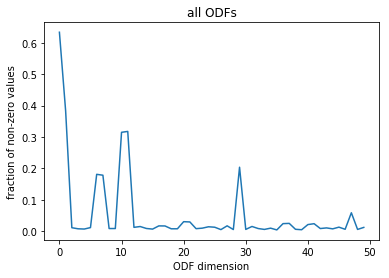

In [31]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","all ODFs")

In [32]:
bestOdfs = odfs[:500]
bestList = []
for i in range(50):
    bestList += [0]
    
for odf in bestOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        bestList[elem] += 1

bestAverage = []
for i in indices:
    bestAverage += [float(bestList[i])/float(len(bestOdfs))]

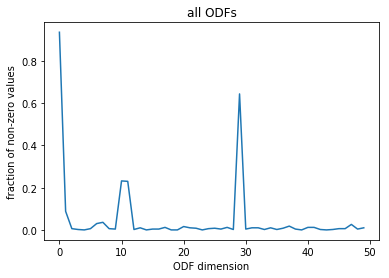

In [34]:
Plot(indices,bestAverage,"ODF dimension","fraction of non-zero values","all ODFs")

In [21]:
maxVal = {'odf':odfs[0]}
savemat('betterSol.mat',maxVal)

In [24]:
dictionary = {}
for i in range(len(indices)):
    dictionary[indices[i]]=topAverage[i]
sorted_dict = sorted(dictionary.items(), key=operator.itemgetter(1),reverse=True)
sorted_dict[:10]

[(0, 0.49405),
 (1, 0.3258),
 (6, 0.25425),
 (7, 0.2515),
 (11, 0.2465),
 (10, 0.24575),
 (29, 0.1234),
 (12, 0.1005),
 (13, 0.0989),
 (47, 0.0679)]

In [26]:
dictionary = {}
for i in range(len(indices)):
    dictionary[indices[i]]=bestAverage[i]
sorted_dict = sorted(dictionary.items(), key=operator.itemgetter(1),reverse=True)
sorted_dict[:7]

[(0, 0.697),
 (10, 0.3585),
 (11, 0.3445),
 (1, 0.3175),
 (29, 0.2935),
 (6, 0.111),
 (7, 0.11)]

## <font color="magenta"> Ideas for analysis </font>

#### Look at the top Solutions
#### Decision Tree and bounds
#### Importance Sampling and Time Reduction 
#### Pattern search and trust region search 

### <font color="crimson"> How do I represent this diversity in a paper </font>

#### <font color="purple"> Almost all the solutions have 0 in them </font>

### <font color="red"> What does it mean non-zero odfs percentage ? Does all good solutions have 0 as one of the dimensions ? </font>

In [28]:
opts[19],odfs[19]

(167.7442339458098,
 [15.984265320842537,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  50.3182621026604,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

### <font color="blue">IDEAS</font>

#### <font color="maroon"> Prediction ? would it make it faster </font>
#### <font color="maroon"> Find top features using decision tree/random forest </font>
#### <font color="maroon"> Get the bounds on top features using decision tree </font>
#### <font color="maroon"> Use it either for pattern search or even intelligent sampling</font>
#### <font color ="maroon"> The idea we thought for multiple solutions. It is there in multiple solutions Notebook (Galfenol)</font>

### <font color="red">STATS</font> 

<font color="purple">  </font>